In [1]:
# %matplotlib widget
import pickle
import ast
import copy
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import cos, radians, sqrt
from datetime import datetime


from concurrent.futures import ThreadPoolExecutor, as_completed

In [ ]:
K_MEAN_MIN = 170
K_MEAN_MAX = 350

# San Francisco square
DATA_SQUARE = { 
                "max_lat": 37.86499,
                "min_lon": -122.53304,
                "min_lat": 37.68481,
                "max_lon": -122.30576
                }


START_TIME = "00:00:00"
END_TIME = "23:00:00"
MINUTE_INTERVAL = 10

DATA_CENTER = {
    "lat": 37.7749,  # Latitude of San Francisco
    "lon": -122.4194  # Longitude of San Francisco
}
POI_LAT = DATA_CENTER["lat"]
POI_LON = DATA_CENTER["lon"]

L_MIN_500 = 500
L_MIN_700 = 700
L_MIN_1000 = 1000

L_MIN = K_MEAN_MIN * 2


working_days = ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]


In [3]:
FILE_PROTECTED = f"../../datasets/PaperResults/sanfrancisco_all_Y_pred_adaptive_k_mean_min{K_MEAN_MIN}_mean_max{K_MEAN_MAX}_ntrajs_19500.pkl"

DENORMALIZER_RANGES_FILE =  "../../datasets/PaperResults/sanfrancisco_all_normalization_ranges_ntrajs_19500.pkl"

FILE_ORIGINAL_PATH = "../../datasets/SanFrancisco/analysis_trajectories_square.pkl"


TRAFFIC_MAP_ORIGINAL_PATH_500 =  "../../datasets/PaperResults/traffic_maps/one_set_three_tensors/sf_traffic_map_500.pkl"
PROTECTED_TRAFFIC_MAP_PATH_500 =  "../../datasets/PaperResults/traffic_maps/one_set_three_tensors/sf_protected_traffic_map_500.pkl"

TRAFFIC_MAP_ORIGINAL_PATH_700 =  "../../datasets/PaperResults/traffic_maps/one_set_three_tensors/sf_traffic_map_700.pkl"
PROTECTED_TRAFFIC_MAP_PATH_700 =  "../../datasets/PaperResults/traffic_maps/one_set_three_tensors/sf_protected_traffic_map_700.pkl"

TRAFFIC_MAP_ORIGINAL_PATH_1000 =  "../../datasets/PaperResults/traffic_maps/one_set_three_tensors/sf_traffic_map_1000.pkl"
PROTECTED_TRAFFIC_MAP_PATH_1000 =  "../../datasets/PaperResults/traffic_maps/one_set_three_tensors/sf_protected_traffic_map_1000.pkl"

In [4]:
def load_object(file_path, encoding=None):
    """
    To be used after calling save_object().
    Loads a python object that was pickled with save_object()

    :param str file_path: Path to the pickled
    :param str encoding: None or type of file encoding
    :return: None if load fails, else the pickled object
    :rtype: None if fails or type of objected pickled with save_object() 
    """
    
    if file_path is not None:

        with open(file_path, 'rb') as file:

            if encoding is not None:
                return pickle.load(file, encoding='latin1')
            else:
                return pickle.load(file)

    return None

In [5]:
def save_object(obj, file_path):
    """
    Save python object obj in the given file_path with pickle.

    :param object obj: Python object to be saved
    :param str file_path: Path where to save obj
    :return: If the save was successful
    :rtype: bool
    """

    if obj is not None and file_path is not None:

        with open(file_path, 'wb') as file:
            pickle.dump(obj, file)

        return True
        
    return False

In [6]:
def denormalize_data(dataset, scaler = None, normalization_ranges = None):
    """
        Function to denormalize the dataset using the scaler used to normalize the dataset.
        Manual denormalization can be used for separate testing data denormalization or for denormalization of the whole dataset.
    """
    dataset_cpy = copy.deepcopy(dataset)
    
    if scaler is None and normalization_ranges is not None:
        X_min = normalization_ranges["min"][:2]
        X_max = normalization_ranges["max"][:2]
        
        dataset_cpy = [arr * (X_max - X_min) + X_min for arr in dataset]
            
    if scaler is not None:
        for item in range(len(dataset)):
            dataset_cpy[item] = scaler.inverse_transform(dataset_cpy[item])
       
    return dataset_cpy

In [7]:
def get_data_in_square(data, square):
    """ Get data inside the square defined by the square dictionary """ 
    
    # Ensure correct bounds regardless of coordinate sign or order
    lat_min = min(square["max_lat"], square["min_lat"])
    lat_max = max(square["max_lat"], square["min_lat"])
    lon_min = min(square["min_lon"], square["max_lon"])
    lon_max = max(square["min_lon"], square["max_lon"])

    filtered_data = []
    
    for traj in data:
        in_lat_bounds = traj["lat"].between(lat_min, lat_max)
        in_lon_bounds = traj["lon"].between(lon_min, lon_max)

        if (in_lat_bounds & in_lon_bounds).all():
            filtered_data.append(traj)
            
            
    return filtered_data

In [8]:
def np_to_df(original_trajectories, protected_trajectories):
    columns = original_trajectories[0].columns
    protected_trajectories_dfs = []

    index = 0
    for traj in original_trajectories:
        df = pd.DataFrame(columns=columns)
        traj = traj.copy()
        df["lat"] = protected_trajectories[index][:, 0]
        df["lon"] = protected_trajectories[index][:, 1]
        df["timestamp"] = traj["timestamp"]
        df["time_diff"] = traj["time_diff"]
        df["distance_km"] = traj["distance_km"]
        df["speed_km"] = traj["speed_km"]
        df["date"] = traj["date"]
        df["time"] = traj["time"]
        index += 1
        protected_trajectories_dfs.append(df)
    return protected_trajectories_dfs

In [9]:
def split_by_area(data_square, target_area_m2):
    """
    Given a square of coordinates data_square, with a target area size in square meters, calculates smaller squares inside data_square.
    Retruns a list of squares inside data_square.
    """
    
    def meters_to_degrees(lat, target_area_m2):
        """
        Computes the coordinates for a target area in square meters.
            - 1° of latitude is approximately 111,000 meters
            - 1° of longitude is approximately 111,320 meters at equator times cos(lat)
        """
        side_m = sqrt(target_area_m2)
        deg_lat = side_m / 111_000
        deg_lon = side_m / (111_320 * cos(radians(lat)))
        return deg_lat, deg_lon

    lat_max = data_square["max_lat"]
    lat_min = data_square["min_lat"]
    lon_min = data_square["min_lon"]
    lon_max = data_square["max_lon"]

    center_lat = (lat_max + lat_min) / 2
    delta_lat, delta_lon = meters_to_degrees(center_lat, target_area_m2)

    lat = lat_min
    squares = []

    while lat < lat_max:
        next_lat = min(lat + delta_lat, lat_max)
        lon = lon_min
        while lon < lon_max:
            next_lon = min(lon + delta_lon, lon_max)
            squares.append({
                "min_lat": lat,
                "max_lat": next_lat,
                "min_lon": lon,
                "max_lon": next_lon
            })
            lon = next_lon
        lat = next_lat

    return squares

In [10]:
def get_points_in_time_range(trajectories, start_time, end_time):
    start_dt = pd.to_datetime(start_time)
    end_dt = pd.to_datetime(end_time)

    filtered_trajectories = []
    for trajectory in trajectories:
        if 'datetime' not in trajectory.columns:
            trajectory = trajectory.copy()
            trajectory['datetime'] = pd.to_datetime(
                trajectory['date'].astype(str) + ' ' + trajectory['time'].astype(str),
                format='%Y-%m-%d %H:%M:%S',
                errors='coerce'
            )

        mask = (trajectory['datetime'] >= start_dt) & (trajectory['datetime'] <= end_dt)
        if mask.any():
            filtered_trajectories.append(trajectory.loc[mask])

    return filtered_trajectories

def _process_trajectory_by_date(args):
    day, trajectories, start_time, end_time = args
    start_dt = f"{day} {start_time}"
    end_dt = f"{day} {end_time}"
    filtered = get_points_in_time_range(trajectories, start_dt, end_dt)
    print(f"Date {day} - Number of trajectories: {len(filtered)}")
    return {'date': day, 'trajectories': filtered}

def get_trajectories_by_date(trajectories, dates, start_time, end_time):
    tasks = [(day, trajectories, start_time, end_time) for day in dates]

    results = []
    with ThreadPoolExecutor() as executor:
        futures = {executor.submit(_process_trajectory_by_date, task): task[0] for task in tasks}
        for future in as_completed(futures):
            result = future.result()
            results.append(result)

    return pd.DataFrame(results)



In [11]:
def get_dates(trajectories):
    """
    Returns a list of unique dates from a list of trajectories.
    
    Each trajectory is a DataFrame with a 'date' column.
    """
    all_dates = pd.concat([df["date"] for df in trajectories], ignore_index=True)
    unique_dates = all_dates.unique()

    return pd.Series(unique_dates)

In [12]:
def split_by_weekday(df):
    weekdays = ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]
    return {day: df[df['date'].dt.weekday == i] for i, day in enumerate(weekdays)}

In [13]:
def get_grid_for_point(lat, lon, grid_squares):
    for idx, square in enumerate(grid_squares):
        if (square['min_lat'] <= lat <= square['max_lat'] and
            square['min_lon'] <= lon <= square['max_lon']):
            return idx
    return None

def plot_traffic_one_day_for_poi(lat, lon, grid_squares, daily_dict, protected_dict, day, lmin="300"):
    grid_idx = get_grid_for_point(lat, lon, grid_squares)
    if grid_idx is None:
        print("Location is not within any grid square.")
        return

    plt.figure(figsize=(14, 7))

    # Plot original data for the specific day
    if day in daily_dict:
        traffic_map = daily_dict[day]["traffic_map"]
        if traffic_map is not None:
            aggregated_time_series = np.sum(traffic_map[grid_idx, :, :], axis=1)
            time_steps = np.arange(len(aggregated_time_series))
            plt.plot(time_steps, aggregated_time_series, marker='o', label=f"{day} original")

    # Plot protected data for the specific day
    if day in protected_dict:
        traffic_map = protected_dict[day]["traffic_map"]
        if traffic_map is not None:
            aggregated_time_series = np.sum(traffic_map[grid_idx, :, :], axis=1)
            time_steps = np.arange(len(aggregated_time_series))
            plt.plot(time_steps, aggregated_time_series, marker='x', label=f"{day} protected")

    num_steps = len(aggregated_time_series)
    time_labels = [f"{(t * 10) // 60:02}:{(t * 10) % 60:02}" for t in range(num_steps)]
    plt.xticks(ticks=np.arange(0, num_steps, 6), labels=time_labels[::6], rotation=45) 

    plt.title(f"Aggregated Traffic for POI at ({lat}, {lon}) on {day} [Grid {grid_idx}] - Lmin: {lmin}")
    plt.xlabel("Time Steps (1 point = 10 min)")
    plt.ylabel("Trajectory points in grid")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

In [14]:
def get_time_intervals(START_TIME, END_TIME, minute_bins):
    start = pd.to_datetime(START_TIME)
    end = pd.to_datetime(END_TIME)
    
    intervals = pd.date_range(start=start, end=end, freq=f'{minute_bins}min', inclusive='left')
    time_intervals = [t.time() for t in intervals]
    time_intervals = np.array(time_intervals)
    return time_intervals

def get_grid_cell(lat, lon, grid_squares):
    for idx, square in enumerate(grid_squares):
        if (square["min_lat"] <= lat < square["max_lat"] and
            square["min_lon"] <= lon < square["max_lon"]):
            return idx
    return None

def get_traffic_map(time_bins, grid_squares, daily_df, START_TIME=START_TIME, END_TIME=END_TIME):
    
    intervals = get_time_intervals(START_TIME, END_TIME, minute_bins=time_bins)
    y_intervals = len(intervals)
    x_bin = len(grid_squares)

    unique_dates = sorted(daily_df["date"].unique())
    z_days = len(unique_dates)

    # Index mapping
    date_to_z = {d: i for i, d in enumerate(unique_dates)}
    interval_to_y = {interval: i for i, interval in enumerate(intervals)}

    # Initialize traffic map
    traffic_map = np.zeros((x_bin, y_intervals, z_days), dtype=int)


    for _, row in daily_df.iterrows():
        date = row['date']
        if date not in date_to_z:
            continue
        z_idx = date_to_z[date]

        traj_list = row['trajectories']

        for df in traj_list:
            df = df.copy()
            df['time_bin'] = df['datetime'].dt.floor(f'{time_bins}min').dt.time

            for _, pt in df.iterrows():
                grid_idx = get_grid_cell(pt.lat, pt.lon, grid_squares)
                time_bin = pt['time_bin']
                if grid_idx is not None and time_bin in interval_to_y:
                    y_idx = interval_to_y[time_bin]
                    traffic_map[grid_idx, y_idx, z_idx] += 1
    
    return traffic_map, unique_dates, intervals

In [15]:
def get_traffic_map_data(dataset_df, grid_squares):
    porto_traffic_maps = {}

    for day, df in dataset_df.items():
        traffic_map_porto, unique_dates_porto, intervals_porto = get_traffic_map(
            MINUTE_INTERVAL, grid_squares, df,
            START_TIME=START_TIME, END_TIME=END_TIME
        )
        porto_traffic_maps[day] = {
            "traffic_map": traffic_map_porto,
            "unique_dates": unique_dates_porto,
            "intervals": intervals_porto
        }
    return porto_traffic_maps

In [16]:
def create_square_bbox(center_lat, center_lon, size_km):
    """
    Create a square bounding box around a central point.

    Args:
        center_lat (float): Latitude of the center point.
        center_lon (float): Longitude of the center point.
        size_km (float): Length of one side of the square in kilometers.

    Returns:
        Dict containing (min_lat, min_lon, max_lat, max_lon).
    """
    data_square = {}
    # Approximate conversion: 1 degree latitude ~ 111 km
    delta_lat = (size_km / 2) / 111.0

    # Approximate conversion: 1 degree longitude ~ 111 km * cos(latitude in radians)
    from math import cos, radians
    delta_lon = (size_km / 2) / (111.0 * cos(radians(center_lat)))

    data_square["min_lat"] = center_lat - delta_lat
    data_square["max_lat"] = center_lat + delta_lat
    data_square["min_lon"] = center_lon - delta_lon
    data_square["max_lon"] = center_lon + delta_lon


    return data_square


In [17]:
normalization_ranges=load_object(DENORMALIZER_RANGES_FILE)
trajectories_protected_norm = load_object(FILE_PROTECTED)

trajectories_protected = denormalize_data(trajectories_protected_norm, normalization_ranges=normalization_ranges)
len_protected = len(trajectories_protected)
print(len_protected)

# Original
trajectories_original = load_object(FILE_ORIGINAL_PATH)
len(trajectories_original)

trajectories_original = get_data_in_square(data=trajectories_original, square=DATA_SQUARE)
len(trajectories_original)

19500


19781

In [18]:
trajectories_subset = trajectories_original[:len_protected]
len(trajectories_subset)

19500

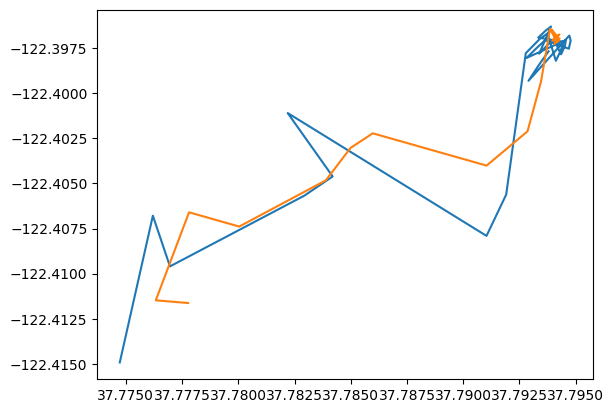

In [19]:
index = 10
plt.figure() # lat lon
plt.plot(trajectories_protected[index][:, 0], trajectories_protected[index][:, 1]) 
plt.plot(trajectories_subset[index].lat, trajectories_subset[index].lon)

In [20]:
# remove the first row from each original trajectory
trajectories_subset = [df.iloc[1:].reset_index(drop=True) for df in trajectories_subset]

In [21]:
len(trajectories_subset[0]) == len(trajectories_subset[0])

True

In [22]:
protected_denorm_df = np_to_df(trajectories_subset, trajectories_protected)

In [23]:
bbox_500 = create_square_bbox(POI_LAT, POI_LON, (L_MIN_500/2)/1000)
bbox_700 = create_square_bbox(POI_LAT, POI_LON, (L_MIN_700/2)/1000)
bbox_1000 = create_square_bbox(POI_LAT, POI_LON, (L_MIN_1000/2)/1000)

In [24]:
def get_points_in_square(data, square):
    """ Get data inside the square defined by the square dictionary. 
        This version retrieves data if at least one point in the trajectory 
        is inside the square's boundaries.
    """
    
    # Ensure correct bounds regardless of coordinate sign or order
    lat_min = min(square["max_lat"], square["min_lat"])
    lat_max = max(square["max_lat"], square["min_lat"])
    lon_min = min(square["min_lon"], square["max_lon"])
    lon_max = max(square["min_lon"], square["max_lon"])

    filtered_data = []
    
    for traj in data:
        # Check if any point in the trajectory lies within the bounds
        in_lat_bounds = traj["lat"].between(lat_min, lat_max)
        in_lon_bounds = traj["lon"].between(lon_min, lon_max)

        # If at least one point is in bounds, include this trajectory
        if (in_lat_bounds | in_lon_bounds).any():
            filtered_data.append(traj)
            
    return filtered_data


In [25]:
trajectories_500 = get_points_in_square(data=trajectories_subset, square=bbox_500)
trajectories_700 = get_points_in_square(data=trajectories_subset, square=bbox_700)
trajectories_1000 = get_points_in_square(data=trajectories_subset, square=bbox_1000)

In [26]:
protected_500 = get_points_in_square(data=protected_denorm_df, square=bbox_500)
protected_700 = get_points_in_square(data=protected_denorm_df, square=bbox_700)
protected_1000 = get_points_in_square(data=protected_denorm_df, square=bbox_1000)

In [27]:
dates = get_dates(trajectories_subset).drop_duplicates()

In [28]:
trajectories_by_date_500 = get_trajectories_by_date(trajectories_500, dates, START_TIME, END_TIME)
protected_by_date_500 = get_trajectories_by_date(protected_500, dates, START_TIME, END_TIME)

Date 2008-06-09 - Number of trajectories: 372
Date 2008-06-06 - Number of trajectories: 470
Date 2008-06-02 - Number of trajectories: 522
Date 2008-05-31 - Number of trajectories: 525
Date 2008-05-27 - Number of trajectories: 683
Date 2008-05-28 - Number of trajectories: 673
Date 2008-06-03 - Number of trajectories: 642
Date 2008-05-30 - Number of trajectories: 599
Date 2008-06-04 - Number of trajectories: 583
Date 2008-06-05 - Number of trajectories: 574
Date 2008-06-08 - Number of trajectories: 533
Date 2008-05-26 - Number of trajectories: 641
Date 2008-05-25 - Number of trajectories: 641
Date 2008-05-24 - Number of trajectories: 591
Date 2008-05-23 - Number of trajectories: 545
Date 2008-05-21 - Number of trajectories: 527
Date 2008-05-20 - Number of trajectories: 595
Date 2008-06-01 - Number of trajectories: 518
Date 2008-05-18 - Number of trajectories: 497
Date 2008-05-17 - Number of trajectories: 360
Date 2008-06-07 - Number of trajectories: 523
Date 2008-06-10 - Number of trajec

In [29]:
# trajectories_by_date_700 = get_trajectories_by_date(trajectories_700, dates, START_TIME, END_TIME)
# protected_by_date_700 = get_trajectories_by_date(protected_700, dates, START_TIME, END_TIME)

In [30]:
# trajectories_by_date_500 = get_trajectories_by_date(trajectories_500, dates, START_TIME, END_TIME)
# protected_by_date_500 = get_trajectories_by_date(protected_500, dates, START_TIME, END_TIME)

In [31]:
# Transform from date string to datetime.date all dates in trajectories_by_dates
trajectories_by_date_500["date"] = pd.to_datetime(trajectories_by_date_500["date"])
protected_by_date_500["date"] = pd.to_datetime(protected_by_date_500["date"])

# trajectories_by_date_700["date"] = pd.to_datetime(trajectories_by_date_700["date"])
# protected_by_date_700["date"] = pd.to_datetime(protected_by_date_700["date"])

# trajectories_by_date_500["date"] = pd.to_datetime(trajectories_by_date_900["date"])
# protected_by_date_900["date"] = pd.to_datetime(protected_by_date_900["date"])


In [32]:
def get_traffic_map_with_flow(time_bins, grid_squares, daily_df, START_TIME=START_TIME, END_TIME=END_TIME):
    """
    Parallelized computation of:
    - point_map: count of trajectory points
    - flow_map: unique vehicles per grid/time
    - avg_traversal_map: average traversal time (seconds) per vehicle
    """

    # Prepare dimensions
    intervals = get_time_intervals(START_TIME, END_TIME, minute_bins=time_bins)
    y_intervals = len(intervals)
    x_bin = len(grid_squares)
    unique_dates = sorted(daily_df["date"].unique())
    z_days = len(unique_dates)

    date_to_z = {d: i for i, d in enumerate(unique_dates)}
    interval_to_y = {interval: i for i, interval in enumerate(intervals)}

    # Initialize result tensors
    point_map = np.zeros((x_bin, y_intervals, z_days), dtype=int)
    flow_map = np.zeros((x_bin, y_intervals, z_days), dtype=int)

    def process_day(row):
        """Process a single day: returns (point_map_day, flow_map_day, z_idx)"""
        date = row['date']
        if date not in date_to_z:
            return None
        z_idx = date_to_z[date]

        local_point_map = np.zeros((x_bin, y_intervals), dtype=int)
        local_flow_map = np.zeros((x_bin, y_intervals), dtype=int)

        traj_list = row['trajectories']

        for vehicle_id, df in enumerate(traj_list):
            df = df.copy()
            df['time_bin'] = df['datetime'].dt.floor(f'{time_bins}min').dt.time

            for time_bin, group in df.groupby('time_bin'):
                y_idx = interval_to_y.get(time_bin)
                if y_idx is None:
                    continue

                visited_grids = set()

                for _, pt in group.iterrows():
                    grid_idx = get_grid_cell(pt.lat, pt.lon, grid_squares)
                    if grid_idx is not None:
                        local_point_map[grid_idx, y_idx] += 1
                        visited_grids.add(grid_idx)

                for grid_idx in visited_grids:
                    local_flow_map[grid_idx, y_idx] += 1

        return local_point_map, local_flow_map, z_idx

    # Parallel processing
    with ThreadPoolExecutor() as executor:
        results = executor.map(process_day, [row for _, row in daily_df.iterrows()])

    # Merge results into global tensors
    for res in results:
        if res is None:
            continue
        local_point_map, local_flow_map, z_idx = res
        point_map[:, :, z_idx] += local_point_map
        flow_map[:, :, z_idx] += local_flow_map

    # Compute average traversal time
    avg_traversal_map = np.zeros_like(point_map, dtype=float)
    mask = flow_map > 0
    avg_traversal_map[mask] = (point_map[mask] * 60) / flow_map[mask]  # 60s per point

    return point_map, flow_map, avg_traversal_map, unique_dates, intervals


In [35]:
point_map_original_500, flow_map_original_500, avg_traversal_original_500, unique_dates_500, intervals_500 = get_traffic_map_with_flow(
    MINUTE_INTERVAL, [bbox_500], trajectories_by_date_500,
    START_TIME=START_TIME, END_TIME=END_TIME
)


In [37]:
point_map_protected_500, flow_map_protected_500, avg_traversal_protected_500, unique_dates_500, intervals_500 = get_traffic_map_with_flow(
    MINUTE_INTERVAL, [bbox_500], protected_by_date_500,
    START_TIME=START_TIME, END_TIME=END_TIME
)


In [40]:
def show_mean_waiting_time_per_weekday(
    lat, lon, grid_squares,
    avg_traversal_original, avg_traversal_protected,
    unique_dates
):
    """
    Compute average waiting time per weekday for a specific grid cell
    in both original and protected datasets.
    """
    from datetime import datetime

    grid_idx = get_grid_for_point(lat, lon, grid_squares)
    if grid_idx is None:
        print("POI is outside the grid area.")
        return

    # Map dates to weekday index (0 = Monday, 6 = Sunday)
    weekday_map = {i: [] for i in range(7)}  # original
    protected_map = {i: [] for i in range(7)}  # protected

    for z, date_str in enumerate(unique_dates):
        weekday = pd.to_datetime(date_str).weekday()  # 0 to 6

        # Extract 1D traversal time series for this day and grid
        original_vals = avg_traversal_original[grid_idx, :, z]
        protected_vals = avg_traversal_protected[grid_idx, :, z]

        # Only nonzero entries (where flow > 0)
        real_nonzero = original_vals[original_vals > 0]
        protected_nonzero = protected_vals[protected_vals > 0]

        if real_nonzero.size > 0:
            weekday_map[weekday].extend(real_nonzero.tolist())

        if protected_nonzero.size > 0:
            protected_map[weekday].extend(protected_nonzero.tolist())

    # Compute mean waiting times
    weekday_names = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
    real_means = [np.mean(weekday_map[i]) if weekday_map[i] else np.nan for i in range(7)]
    protected_means = [np.mean(protected_map[i]) if protected_map[i] else np.nan for i in range(7)]

    # Display results
    print(f"\nAverage Waiting Time by Weekday for Grid {grid_idx}:")
    for i in range(7):
        print(f"{weekday_names[i]}: Real = {real_means[i]:.2f}s | Protected = {protected_means[i]:.2f}s")

    # Optional: return for plotting
    return weekday_names, real_means, protected_means

show_mean_waiting_time_per_weekday(
    lat=37.7749, lon=-122.4194,
    grid_squares=[bbox_500],
    avg_traversal_original=avg_traversal_original_500,
    avg_traversal_protected=avg_traversal_protected_500,
    unique_dates=unique_dates_500
)



Average Waiting Time by Weekday for Grid 0:
Mon: Real = 78.81s | Protected = 76.29s
Tue: Real = 73.99s | Protected = 85.26s
Wed: Real = 76.38s | Protected = 76.74s
Thu: Real = 84.20s | Protected = 86.87s
Fri: Real = 99.00s | Protected = 103.53s
Sat: Real = 74.48s | Protected = 80.73s
Sun: Real = 76.80s | Protected = 81.17s


(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
 [78.80952380952381,
  73.9940119760479,
  76.38157894736842,
  84.20454545454545,
  99.0,
  74.48170731707317,
  76.8],
 [76.29139072847683,
  85.26315789473684,
  76.73758865248227,
  86.87022900763358,
  103.53125,
  80.73417721518987,
  81.16766467065868])

In [42]:

save_object(point_map_original_500, 
            "../../datasets/PaperResults/traffic_maps/one_set_three_tensors/sf_traffic_map_500")
save_object(flow_map_original_500, 
            "../../datasets/PaperResults/traffic_maps/one_set_three_tensors/sf_flow_map_500")
save_object(avg_traversal_original_500, 
            "../../datasets/PaperResults/traffic_maps/one_set_three_tensors/sf_avgtrav_map_500")
save_object(unique_dates_500, 
            "../../datasets/PaperResults/traffic_maps/one_set_three_tensors/sf_dates_map_500")
save_object(intervals_500, 
            "../../datasets/PaperResults/traffic_maps/one_set_three_tensors/sf_intervals_map_500")


save_object(point_map_protected_500, 
            "../../datasets/PaperResults/traffic_maps/one_set_three_tensors/sf_protected_traffic_map_500")
save_object(flow_map_protected_500, 
            "../../datasets/PaperResults/traffic_maps/one_set_three_tensors/sf_protected_flow_map_500")
save_object(avg_traversal_protected_500, 
            "../../datasets/PaperResults/traffic_maps/one_set_three_tensors/sf_protected_avgtrav_map_500")

True

In [ ]:
# porto_working_days_dict_300 = {day: traffic_map[day] for day in working_days if day in traffic_map}
# protected_working_days_dict_34000 = {day: protected_traffic_map[day] for day in working_days if day in protected_traffic_map}


In [ ]:
# for day in working_days:
#     plot_traffic_one_day_for_poi(POI_LAT, POI_LON, grid_squares, porto_working_days_dict_300, protected_working_days_dict_34000, day, lmin=L_MIN)